In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn_hierarchical_classification.classifier import HierarchicalClassifier
from sklearn_hierarchical_classification.constants import ROOT
from sklearn_hierarchical_classification.metrics import h_fbeta_score, multi_labeled

from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.pipeline import make_pipeline

In [2]:

df = pd.read_csv('dataset.csv')
X = df.drop(columns=['Activity'])
y = df['Activity']

metrics = ['f1_weighted', 'balanced_accuracy', 'accuracy']

In [4]:
'''
T  -> Postural Transitions
NT -> Non Transitions

    <ROOT>
   /      \
  T        NT
 / \      /  \
.. ..    ..  ..
'''
class_hierarchy = {
    ROOT: ["T", "NT"],
    "NT": ['STANDING', 'LAYING', 'SITTING', 'WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS'],
    "T": ['STAND_TO_LIE', 'SIT_TO_LIE', 'LIE_TO_SIT', 'LIE_TO_STAND', 'STAND_TO_SIT', 'SIT_TO_STAND'],
}

steps = [
            SMOTE(random_state=42, n_jobs=-1),
            MLPClassifier(activation = 'logistic',
                        solver='adam',
                        alpha=1e-5,
                        learning_rate = 'invscaling',
                        max_iter = 600,
                        hidden_layer_sizes=(100,),
                        random_state=42)
]
t_clf = make_pipeline(*steps)

base_estimator = {
    ROOT: SVC(C=100, kernel='rbf', probability=True, random_state=42),
    "NT": MLPClassifier(activation = 'logistic',
                    solver='adam',
                    alpha=1e-5,
                    learning_rate = 'invscaling',
                    max_iter = 500,
                    hidden_layer_sizes=(400,),
                    random_state=42),
    "T": t_clf,
}

clf = HierarchicalClassifier(
    base_estimator=base_estimator,
    class_hierarchy=class_hierarchy,
    prediction_depth='mlnp',
    algorithm='lcpn',
)

In [4]:
result = cross_validate(clf, X, y, cv=10, scoring=metrics,
                        return_train_score=True, n_jobs=-1)

print("\tf1:")
print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
    .format(mean = result.get('test_f1_weighted').mean()*100,
            std = result.get('test_f1_weighted').std()))

print("\tbalanced accuracy:")
print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
    .format(mean = result.get('test_balanced_accuracy').mean()*100,
            std = result.get('test_balanced_accuracy').std()))

print("\taccuracy:")
print("\t\tmean = {mean:.2f}%;\n\t\tstd = {std:.2f};"
      .format(mean = result.get('test_accuracy').mean()*100,
              std = result.get('test_accuracy').std()))

	f1:
		mean = 94.80%;
		std = 0.02;
	balanced accuracy:
		mean = 85.12%;
		std = 0.03;
	accuracy:
		mean = 94.84%;
		std = 0.02;


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.7, random_state=42)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       587
        LIE_TO_SIT       0.78      0.81      0.79        26
      LIE_TO_STAND       0.74      0.68      0.71        25
           SITTING       0.97      0.96      0.96       540
        SIT_TO_LIE       0.71      0.84      0.77        32
      SIT_TO_STAND       0.64      0.90      0.75        10
          STANDING       0.97      0.98      0.97       594
      STAND_TO_LIE       0.89      0.79      0.84        42
      STAND_TO_SIT       0.81      0.62      0.70        21
           WALKING       1.00      1.00      1.00       517
WALKING_DOWNSTAIRS       1.00      1.00      1.00       422
  WALKING_UPSTAIRS       0.99      1.00      1.00       463

          accuracy                           0.98      3279
         macro avg       0.88      0.88      0.87      3279
      weighted avg       0.98      0.98      0.98      3279



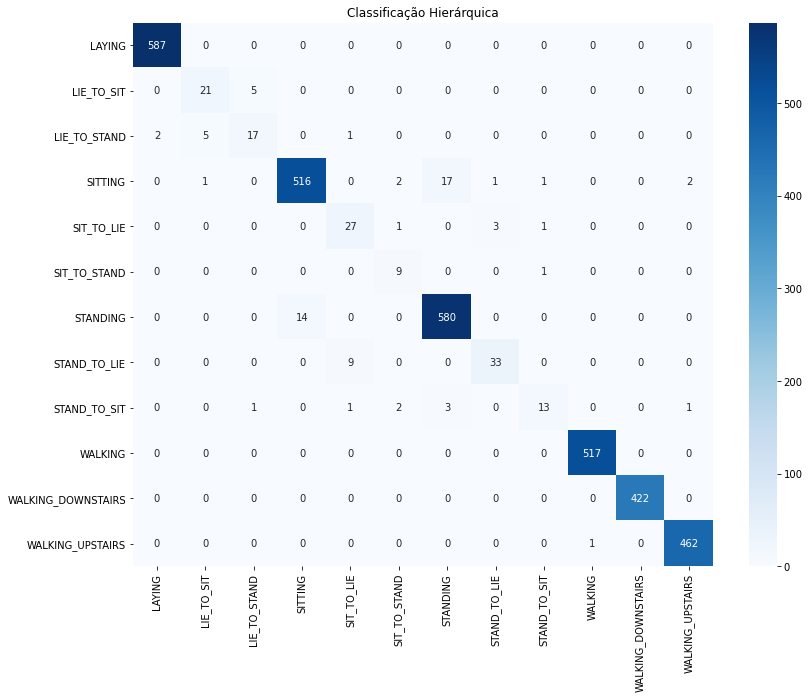

In [6]:
cf_matrix = confusion_matrix(y_test, y_pred)

categories = np.unique(y).tolist()
plt.figure(figsize=(13,10))
plt.title('Classificação Hierárquica')
sns.heatmap(cf_matrix, annot=True, fmt="", cmap='Blues', cbar=True, xticklabels=categories, yticklabels=categories)

In [7]:
with multi_labeled(y_test, y_pred, clf.graph_) as (y_test_, y_pred_, graph_):
    h_fbeta = h_fbeta_score(
        y_test_,
        y_pred_,
        graph_,
    )
    print("h_fbeta_score: ", h_fbeta)

h_fbeta_score:  0.9993098688750862


/home/gabriel/.pyenv/versions/anaconda3-2020.07/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:994: UserWarning: unknown class(es) ['A', 'D', 'E', 'G', 'I', 'K', 'L', 'N', 'O', 'P', 'R', 'S', 'U', 'W', 'Y', '_'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'


## Another oversample

In [5]:
steps = [
            BorderlineSMOTE(random_state=42, n_jobs=-1),
            MLPClassifier(activation = 'logistic',
                        solver='adam',
                        alpha=1e-5,
                        learning_rate = 'invscaling',
                        max_iter = 600,
                        hidden_layer_sizes=(125,),
                        random_state=42)
]
t_clf = make_pipeline(*steps)

base_estimator = {
    ROOT: SVC(C=100, kernel='rbf', probability=True, random_state=42),
    "NT": MLPClassifier(activation = 'logistic',
                    solver='adam',
                    alpha=1e-5,
                    learning_rate = 'invscaling',
                    max_iter = 500,
                    hidden_layer_sizes=(400,),
                    random_state=42),
    "T": t_clf,
}

clf = HierarchicalClassifier(
    base_estimator=base_estimator,
    class_hierarchy=class_hierarchy,
    prediction_depth='mlnp',
    algorithm='lcpn',
)